# Tutorial on Basic Diffusion Analysis with GEMDAT

Welcome to this tutorial on diffusion analysis using the **GEMDAT** Python library for Molecular Dynamics (MD) simulations. GEMDAT is a powerful tool built on top of [Pymatgen](https://pymatgen.org/), which makes it straightforward to integrate into your existing Pymatgen-based workflows for materials analysis.

In this workshop, we'll introduce the basics of diffusion analysis with Gemdat. You'll learn how to:

- Import and process MD simulation data
- Perform diffusion analysis using GEMDAT
- Perform site analysis using GEMDAT
- Interpret and visualize the results

### Loading Trajectory Data

In this section, we'll learn how to load trajectory data from a **VASP** simulations into GEMDAT and explore its basic properties. You can also use **LAMMPS**, **GROMACS**, or **ASE** data.
For this tutorial, we provide VASP simulation data. However, if you're interested in using data from other MD software, feel free to use your own datasets or explore the [GEMDAT test data repository](https://github.com/GEMDAT-repos/test_data) for additional examples.

[GEMDAT Trajectory](https://gemdat.readthedocs.io/en/latest/api/gemdat_trajectory/#gemdat.trajectory.Trajectory) is an extension of Pymatgen's [Trajectory class](https://pymatgen.org/pymatgen.core.html#pymatgen.core.trajectory.Trajectory). It supports all the Pymatgen methods to create a trajectory, as well as additional methods to load data depending on your MD software.

Depending on the software used, you can load your simulation data as follows:

- **VASP**
  ```python
  Trajectory.from_vasprun('path/to/your/vasprun.xml')
  ```
- **LAMMPS**
  ```python
  Trajectory.from_lammps('path/to/coords_file', 'path/to/data_file', temperature=300, time_step=0.001)
  # Replace with your simulation temperature and time step of the simulation in ps
  ```
- **GROMACS**
  ```python
  Trajectory.from_gromacs('path/to/topology_file', 'path/to/coords_file', temperature=300)
  # Replace with your simulation temperature
  ```
- **ASE**
  ```python
  Trajectory.from_ase_trajectory('path/to/md.traj', temperature=300, time_step_ps=0.002)
  # Replace with your simulation temperature and time step of the simulation in ps
  ```

Let's proceed to load the trajectory data from a VASP simulation. We provide data for this workshop, but feel free to use your own data if available.

In [1]:
# Import necessary libraries
import os
import numpy as np
from gemdat import Trajectory
from gemdat.metrics import TrajectoryMetricsStd, ArrheniusFit
from gemdat.io import read_cif, write_cif
from gemdat.shape import ShapeAnalyzer


# This block will suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the path to workshop folder
os.chdir('path/to/workshop/folder')

# Define the path to VASP data
VASPRUN = 'data/vasprun.xml'

# Read and cache the trajectory data
trajectory = Trajectory.from_vasprun(VASPRUN, cache='data/vasprun.xml.a45e320a.cache')

> **Note 1**: The code automatically caches the loaded data using pickle, saving time when rerunning.
>
> **Note 2**: If you are loading relaxation or NpT data, use the flag `constant_lattice=False` to allow for volume change.
>
> **Note 3**: For very large trajectories, you might want to limit the number of time steps or load a subset of the data to conserve memory using, e.g., `ionic_step_skip=10` or `ionic_step_offset=2500`.

### Exploring the Trajectory

Once the trajectory is loaded, let’s explore its basic properties. Printing the trajectory object provides a concise summary of its contents:

In [3]:
# Print summary of the loaded trajectory
print(trajectory)

Full Formula (Na46 Sb14 W2 S64)
Reduced Formula: Na23Sb7WS32
abc   :  14.437000  14.437028  14.475216
angles:  90.000427  89.999751  90.237694
pbc   :       True       True       True
Constant lattice (True)
Sites (126)
Time steps (25000)


Here we will investigate AIMD simulation of $Na_3(Sb/W)S_4$ structure



You can also access specific attributes for more detailed information:

In [4]:
# Retrieve and print key attributes of the trajectory

# Simulation temperature (K)
temperature = trajectory.metadata['temperature']
print(f"Simulation temperature: {temperature} K")

# Total simulation time in seconds
simulation_time = trajectory.total_time
print(f"Total simulation time: {simulation_time} s")

# Time step in picoseconds
time_step = trajectory.time_step_ps # or time_step = trajectory.time_step for seconds
print(f"Time step: {time_step} ps")

# Number of time steps
n_timesteps = len(trajectory)
print(f"Number of time steps: {n_timesteps}")

# Unique species in the simulation
species = trajectory.species
print(f"Unique species in the simulation: {set(species)}")

# Lattice of the simulation cell at time step 0
lattice = trajectory.get_lattice(0)
print(f"Volume of the simulation cell at time step 0: {lattice.volume:.2f} Å³")

# Structure at time step 0
structure = trajectory.get_structure(0)
print(f"Structure composition at Time Step 0: {structure.composition}")

# Coordinates (fractional)
coords = trajectory.coords  # or trajectory.positions
print(f"Shape of coordinates (time steps, atoms, dimensions): {coords.shape}")

Simulation temperature: 500.0 K
Total simulation time: 5e-11 s
Time step: 0.002 ps
Number of time steps: 25000
Unique species in the simulation: {Element W, Element S, Element Na, Element Sb}
Volume of the simulation cell at time step 0: 3017.01 Å³
Structure composition at Time Step 0: Na46 Sb14 W2 S64
Shape of coordinates (time steps, atoms, dimensions): (25000, 126, 3)


You can slice the trajectory to exclude specific time steps. For example, to exclude the first 100 time steps:

In [5]:
# Exclude the first 100 time steps from the trajectory
nr_first_steps = 500
print(f"Initial trajectory: {len(trajectory)} steps")
trajectory_sliced = trajectory[nr_first_steps:]
print(f"Trajectory after excluding the first {nr_first_steps} steps: {len(trajectory_sliced)} steps")

Initial trajectory: 25000 steps
Trajectory after excluding the first 500 steps: 24500 steps


To focus on certain species, you can filter the trajectory. For instance, to extract a trajectory containing only antimony (Sb) and tungsten (W) atoms:

In [6]:
# Filter the trajectory to include only Sb and W atoms
filtered_trajectory = trajectory.filter(['Sb', 'W'])
print(f"Filtered Trajectory Species: {set(filtered_trajectory.species)}")

Filtered Trajectory Species: {Element W, Element Sb}


You can also split the trajectory into multiple parts, which can be useful for analyzing separate segments:

In [7]:
# Split the trajectory into 10 equal parts
list_of_trajectories = trajectory.split(n_parts=10, equal_parts=True)
print(f"Number of trajectories after split: {len(list_of_trajectories)}")

# Example: Access the first split trajectory
first_split = list_of_trajectories[0]
print(f"Length of the first split trajectory: {len(first_split)} steps")

Number of trajectories after split: 10
Length of the first split trajectory: 2499 steps


GEMDAT `Trajectory` can be converted to an [ASE](https://ase-lib.org/) `Trajectory` object for seamless integration with the ASE workflows.

In [8]:
ase_traj = trajectory[:500].to_ase_trajectory()
ase_traj.close()

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <p>Save the structure at the last step of the simulation to a <code>.cif</code> file and visualize it with any preferred software.</p>
> </div>

In [9]:
structure_last_step = trajectory[-1]
write_cif(structure=structure_last_step,filename='structure_last_step.cif')

### Analysing the Trajectory. Basic properties

[Gemdat `TrajectoryMetrics` class](https://gemdat.readthedocs.io/en/latest/api/gemdat_simulation_metrics/#gemdat.metrics.TrajectoryMetrics) computes various metrics from an MD simulation. We'll illustrate a few important ones.

First, we’ll filter the trajectory to focus on the diffusing atoms (Na in this case). For some of the upcoming analyses, only the trajectory of the diffusing species is necessary.

In [10]:
# Extract the trajectory of diffusing atoms (Na in this case)
diff_trajectory = trajectory.filter('Na')

# Create a TrajectoryMetrics object for these Na atoms
diff_metrics = diff_trajectory.metrics()

We can calculate the particle density and concentration of the diffusing atoms:

In [11]:
# Get concentration of diffusing atoms
particle_density = diff_metrics.particle_density()
concentration = diff_metrics.mol_per_liter()

print(f"Particle density of the diffusing element: {particle_density:.1e} atoms/m³")
print(f"Concentration of the diffusing element: {concentration:.2f} mol/L")

Particle density of the diffusing element: 1.5e+28 atoms/m³
Concentration of the diffusing element: 25.32 mol/L


#### 1. Amplitude of Vibrations

Atomic vibrations in a crystal describe the motion of atoms around their (meta-)stable positions. From an MD simulation, positions of atoms at all time steps are known, allowing for the calculation of atomic displacements.

GEMDAT uses changes in the derivative of atomic displacement to identify vibrational motion. The vibrational amplitudes ($A$) are obtained by calculating the change in absolute displacement ($r_i$) of each atom ($i$) while the derivative of the displacement maintains the same sign (between time steps $t_a$ and $t_b$): $$ A = r_i(t_b) - r_i(t_a)$$

Fitting a Gaussian to the distribution of vibrational amplitudes yields an estimate for the average amplitude of atomic vibrations.


In [12]:
# Uncomment %matplotlib if needed for interactive plotting (adjust according to your environment)
#%matplotlib notebook

Average vibrational amplitude: 0.510 Å


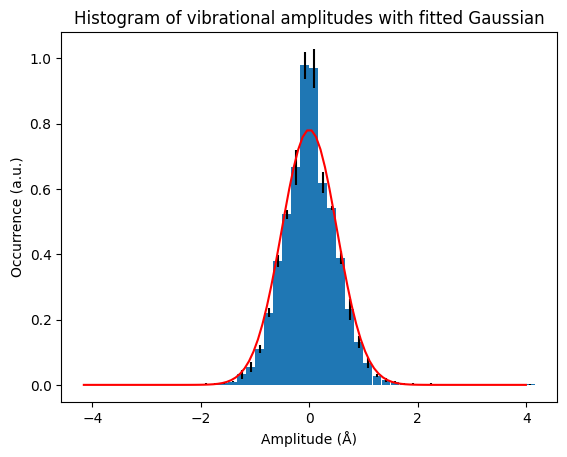

In [13]:
# Plot histogram of vibrational amplitudes with a Gaussian fit
fig = diff_trajectory.plot_vibrational_amplitudes(bins=50, n_parts = 5, backend='matplotlib')
fig.show()

# Calculate and print the average vibrational amplitude
avg_vibration_amplitude = diff_metrics.vibration_amplitude()
print(f"Average vibrational amplitude: {avg_vibration_amplitude:.3f} Å")

> **Note**:
> - GEMDAT has several built-in [plotting functions](https://gemdat.readthedocs.io/en/latest/plotting/#trajectory-and-displacements-plots). Plotly creates interactive plots, while matplotlib typically renders faster for larger datasets. By default, plotly is used, but you can switch to matplotlib using the `backend='matplotlib'` option.
>
> - To make matplotlib interactive, use environment-specific commands such as `%matplotlib notebook` (PyCharm), `%matplotlib widget` (VSCode), or `%matplotlib auto` (Spyder).

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <li>1. Enable interactive matplotlib plots and rerun the relevant cells.</li>
>   <li>2. Try running the same plots with the <code>plotly</code> backend to see the difference.</li>
> </div>

#### 2. Attempt Frequency

We can compute a vibration frequency spectrum via a Fourier transform of atomic displacement derivatives. The vibrational spectrum is obtained by computing the derivative of the absolute displacement ($\Delta r_i$) per atom ($i$) at every time step ($t$): $$\Delta r_i(t)=r_i(t) - r_i(t-1)$$
The vibration frequency (also known as the attempt frequency, ($\nu^*$) can then be derived from the Fourier transformation of this spectrum. This frequency is often used in rate theory to estimate jump rates.

> **Note**: This approach is distinct from a phonon spectrum, since it examines vibrations of individual atoms rather than collective modes.

Attempt frequency: (4.26e+12 ± 6.25e+11) Hz


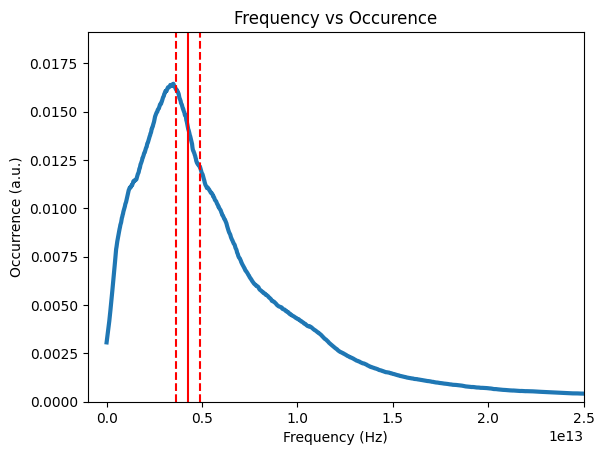

In [14]:
# Plot the vibration frequency spectrum of Na ions
fig = diff_trajectory.plot_frequency_vs_occurence(backend='matplotlib')
fig.show()

# Calculate the attempt frequency and its std
attempt_frequency, attempt_frequency_std = diff_metrics.attempt_frequency()
print(f"Attempt frequency: ({attempt_frequency:.2e} ± {attempt_frequency_std:.2e}) Hz")

#### 3. Displacements

The mean squared displacement (MSD) measures how far, on average, particles move from their initial positions over time. Several definitions of MSD are commonly used:
* **Direct**: $$ MSD(t) = \frac{1}{N} \sum_i^N \left(r_i(t)-r_i(0)\right)^2 ,$$ which simply computes how much particles have moved from their initial positions after time $t$.
* **Multi-start direct**: $$ MSD(t) = \frac{1}{N * [\mathcal{T}]} \sum_{t_0 \in \mathcal{T}} \sum_i^N \left(r_i(t+t_0)-r_i(t_0)\right)^2 ,$$ which averages the direct method over different starting times $t_0$ in a finite set $\mathcal{T}={0, 10s, 20s, \cdots}$, improving statistical accuracy. This method is $[\mathcal{T}]$ times as slow as the direct one, but it can be parallelized for optimal performance.
* **Window method**: $$ MSD(t) = \frac{1}{N}  \sum_i^N \frac{1}{N-t} \sum_{s=0}^{N-t-1} \left(r_i(t+s)-r_i(s)\right)^2 ,$$ which extends the multi-start method to include all possible time windows of size $t$. This method is more computationally demanding than the others, but it can be formulated using FFT making it very efficient, while retaining its superior precision.

GEMDAT implements the **window method** using **FFT** (from [Calandrini et al. (2011)](https://www.neutron-sciences.org/articles/sfn/abs/2011/01/sfn201112010/sfn201112010.html) for efficient calculation.

Let’s compute and visualize the MSD of the diffusing atoms. We’ll start by calculating the MSD for Na and plotting the MSD evolution over time.

In [15]:
# Calculate the mean squared displacement for diffusing atoms
msd_data = diff_trajectory.mean_squared_displacement()

# Extract the MSD at the last time step
msd_last_time_step = np.mean(msd_data[:, -1])

print(f"Na-ion MSD after {simulation_time / 1e-12:.0f} ps AIMD ({temperature:.0f} K): {msd_last_time_step:.2f} Å²")

# Plot MSD evolution over time for each element in the structure
fig = trajectory.plot_msd_per_element()
fig.show()

Na-ion MSD after 50 ps AIMD (500 K): 17.02 Å²


Besides the MSD, GEMDAT can also visualize displacements for each element or each individual atom.

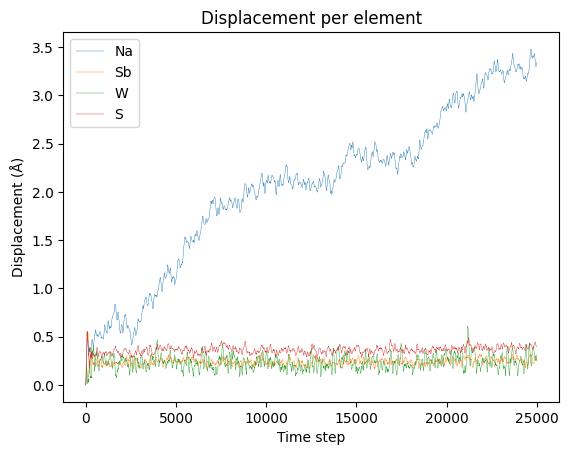

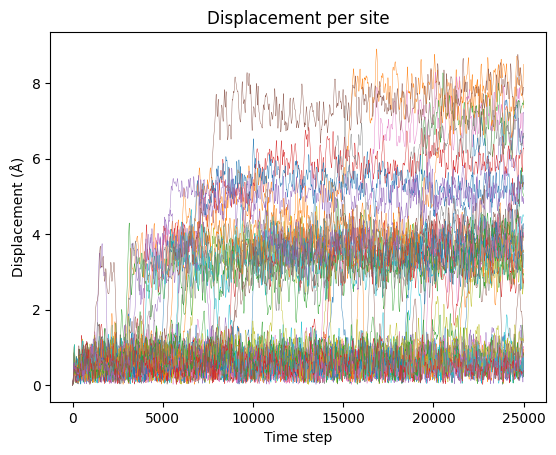

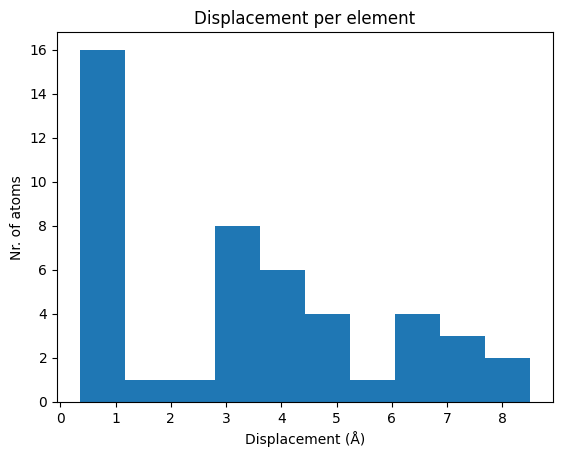

In [16]:
# Plot displacement evolution over time for each element
fig = trajectory.plot_displacement_per_element(backend='matplotlib')
fig.show()

# Plot displacement evolution for each diffusing atom
fig = diff_trajectory.plot_displacement_per_atom(backend='matplotlib')
fig.show()

# Plot histogram of final displacements of diffusing atoms
fig = diff_trajectory.plot_displacement_histogram(backend='matplotlib')
fig.show()


#### 4. Diffusion Properties

From the MSD, you can estimate the **tracer diffusivity** ($D^*$): $$D^*=\frac{1}{2dNt} \sum_{i=1}^N \left(r_i(t+t_0)-r_i(t_0)\right)^2 ,$$
where $r_i(t+t_0)$ is the displacement of a single atom with respect to the starting position $r_i(t_0)$, $t$ the simulated time, $N$ the number of diffusing atoms, and $d$ the number of diffusion dimensions.

GEMDAT offers a direct calculation of tracer diffusivity, followed by **ionic conductivity** ($σ$) via the Nernst−Einstein relation:
$$σ=\frac{ne^2z^2}{k_bT} D^*$$
where $n$ is the diffusing particle density, $e$ the elementary electron charge, $z$ the ionic charge, $k_B$ Boltzmann’s constant, and $T$ the temperature in Kelvin.

Let’s calculate the tracer diffusivity and conductivity for Na atoms.

In [17]:
# Calculate tracer diffusivity for Na (assuming 3D diffusion)
tracer_diffusivity = diff_metrics.tracer_diffusivity(dimensions=3)
print(f"Tracer diffusivity of Na-ions at {temperature:.0f} K: {tracer_diffusivity:.2e} m²/s")

# Calculate tracer conductivity for Na
tracer_conductivity = diff_metrics.tracer_conductivity(z_ion=1, dimensions=3)
print(f"Tracer conductivity of Na-ions at {temperature:.0f} K: {tracer_conductivity:.2f} S/m")

Tracer diffusivity of Na-ions at 500 K: 5.67e-10 m²/s
Tracer conductivity of Na-ions at 500 K: 32.16 S/m


#### 6. Statistical Error Estimation

The [GEMDAT `TrajectoryMetricsStd` class](https://gemdat.readthedocs.io/en/latest/api/gemdat_simulation_metrics/#gemdat.metrics.TrajectoryMetricsStd) estimates statistical uncertainties from a list of trajectories.

In the example below, we estimate errors by splitting the original trajectory into 10 equal parts and computing the mean and standard deviation across these segments. Alternatively, you can provide multiple independent MD trajectories to obtain uncertainty estimates in the same way.


In [18]:
# Split the diffusing atom trajectory into 10 equal parts
list_of_trajectories = diff_trajectory.split(n_parts=10, equal_parts=True)

# Create a TrajectoryMetricsStd object
diff_metrics_std = TrajectoryMetricsStd(trajectories=list_of_trajectories)

# Calculate average vibrational amplitude with standard deviation
avg_vib_amp = diff_metrics_std.vibration_amplitude()
print(f"Average vibrational amplitude: {avg_vib_amp:.3f} Å")

# Calculate tracer diffusivity with standard deviation
avg_tracer_diffusivity = diff_metrics_std.tracer_diffusivity(dimensions=3)
print(f"Tracer diffusivity of Na-ions at {temperature:.0f} K: {avg_tracer_diffusivity:.2e} m²/s")

# Calculate tracer conductivity with standard deviation
avg_tracer_conductivity = diff_metrics_std.tracer_conductivity(z_ion=1, dimensions=3)
print(f"Tracer conductivity of Na-ions at {temperature:.0f} K: {avg_tracer_conductivity:.2f} S/m")

Average vibrational amplitude: 0.495+/-0.033 Å
Tracer diffusivity of Na-ions at 500 K: (6.42+/-3.52)e-10 m²/s
Tracer conductivity of Na-ions at 500 K: 36.40+/-19.93 S/m


#### 7. Arrhenius fit

The `ArrheniusFit` class provides functions to fit tracer diffusivity as a function of temperature using an Arrhenius relation:

$$D^*(T) = D_0 \exp\left(\frac{-E_a}{k_B T}\right)$$

where $D^*$ is the tracer diffusivity (typically in $\mathrm{m^2\,s^{-1}}$), $D_0$ is the prefactor (same units as $D^*$), $E_a$ is the activation energy (eV), $k_B$ is Boltzmann’s constant, and $T$ is the temperature (K).

The fit is performed in log-space by regressing $\ln(D^*)$ against $1/T$:

$$\ln(D^*) = \ln(D_0) - \frac{E_a}{k_B}\left(\frac{1}{T}\right)$$

In addition to fitting $E_a$ and $D_0$, `ArrheniusFit` provides helper methods to extrapolate tracer diffusivity and conductivity at a given temperature using the same definitions as GEMDAT metrics.

`ArrheniusFit` requires a list of trajectories obtained at different temperatures. For the purpose of this tutorial, we demonstrate the workflow using a *synthetic* list of trajectories generated from a single trajectory by splitting it into parts. This produces valid input for the API, but the resulting $E_a$ and $D_0$ values are not physically meaningful. For quantitative analysis, independent simulations at several temperatures are required.

Activation energy from Arrhenius fit: 0.068+/-0.125 eV
Prefactor from Arrhenius fit: (2.101+/-5.660)e-09 m²/s
Extrapolate conductivity at 300 K: 14.19+/-30.38 S/m


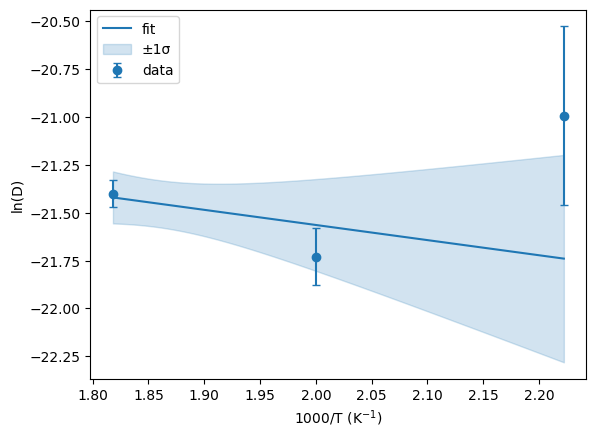

In [19]:
import copy

# Create a synthetic list of trajectories
fake_arrhenius_list = trajectory.split(n_parts=3)
for idx, temp in enumerate([450, 500, 550]):
    traj = copy.deepcopy(fake_arrhenius_list[idx])
    traj.metadata['temperature'] = temp
    fake_arrhenius_list[idx] = traj

# Generate `ArrheniusFit` object
arrhenius = ArrheniusFit.from_trajectories(trajectories=fake_arrhenius_list, diffusing_specie='Na', dimensions=3, n_parts=2)

# Print activation energy from the fit
e_act = arrhenius.activation_energy()
print(f"Activation energy from Arrhenius fit: {e_act:.3f} eV")

# Print prefactor from the fit
prefactor = arrhenius.prefactor()
print(f"Prefactor from Arrhenius fit: {prefactor:.3e} m²/s")

# Extrapolate conductivity at 300 K
extrapolated_conductivity = arrhenius.extrapolate_conductivity(temperature=300, z_ion=1)
print(f"Extrapolate conductivity at 300 K: {extrapolated_conductivity:.2f} S/m")

# Plot Arrhenius fit
fig = arrhenius.plot_arrhenius(backend='matplotlib')
fig.show()

#### 8. Diffusion Analysis with `kinisi`

`kinisi` is an open-source [Python package](https://github.com/kinisi-dev/kinisi.git) for computing mean-squared displacements (MSD) with accurate uncertainty estimation. It also supports estimating diffusion coefficients by performing a linear fit to the diffusive regime of the MSD curve. For details, see the package documentation.

GEMDAT integrates with `kinisi` via the `DiffusionAnalyzer` class and provides plotting functions.

Below is an example workflow showing how to compute the MSD and estimate the diffusion coefficient.

In [20]:
# Create the DiffusionAnalyzer class
shorter_trajectory = trajectory[10000:12000]
kinisi_diff = shorter_trajectory.to_kinisi_diffusion_analyzer(specie='Na')

# Investigate the calculated data
kinisi_diff.da

Finding Means and Variances: 100%|██████████| 2000/2000 [00:03<00:00, 537.69it/s] 

This analysis uses the `kinisi` package. Please cite kinisi and report the kinisi version used. See kinisi documentation (https://github.com/kinisi-dev/kinisi.git) for citation guidance.


<scipp.DataArray>
Dimensions: Sizes[time interval:2000, ]
Coordinates:
* n_samples                 float64  [dimensionless]  (time interval)  [92000, 46000, ..., 46.023, 46]
* time interval             float64             [ps]  (time interval)  [0.002, 0.004, ..., 3.998, 4]
Data:
                            float64           [Å^2]  (time interval)  [0.000222146, 0.000888066, ..., 0.967202, 0.968285]  [3.49431e-13, 1.11625e-11, ..., 0.0373019, 0.0378061]

`DiffusionAnalyzer` computes the MSD and its variance. The analyzer returned by `trajectory.to_kinisi_diffusion_analyzer(...)` keeps an in-memory (runtime) cache of these results to avoid expensive recomputation.

If you call `trajectory.to_kinisi_diffusion_analyzer(...)` with different run parameters, the MSD and variance will be recomputed and the cache will be updated. To force a recomputation even when a cached result exists, pass `return_cache=False`.


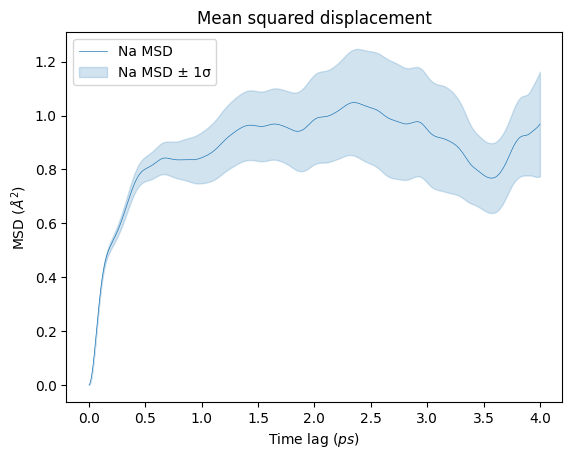

In [21]:
# Plot MSD evolution over time for diffusion specie
fig = shorter_trajectory.plot_msd_kinisi(specie='Na', backend='matplotlib')
fig.show()

From the MSD plot, the diffusive regime is typically identified as the time window where the MSD becomes approximately linear. In this example, diffusive regime is not observed. To keep the workflow demonstrable, we assume an onset of diffusion at 1 ps. This choice is only to provide a working example and the resulting diffusion coefficient should not be considered physically meaningful.

We use `1 * sc.Units("ps")` as the start time for the diffusion analysis below. We also set `random_state` to ensure the analysis is reproducible.


In [22]:
import scipp as sc

# Calculate diffusion coefficient
kinisi_diff.diffusion(start_dt=1*sc.Unit('ps'), random_state=np.random.RandomState(42))

# Print diffusion coefficient
kinisi_diff.D

Likelihood Sampling: 100%|██████████| 1500/1500 [00:42<00:00, 35.02it/s]


<scipp.Variable> (samples: 3200)    float64         [cm^2/s]  [3.89729e-06, 1.46021e-06, ..., 2.53677e-06, 3.88629e-06]

#### 9. Radial Distribution Function

The Radial Distribution Function (RDF) reveals the density of an element versus distance from another element during the MD simulation. The RDF is determined by calculating the distance between all species pairs for each time step and binning them into a histogram. The histogram is then normalized, where normalization is the number density of the system multiplied by the volume of the spherical shell.

Below, we calculate the RDF of Na relative to Sb and W:

In [23]:
# Calculate the RDF between Na and [Sb, W]
rdf_cations = trajectory.radial_distribution_between_species(
    specie_1='Na', specie_2=['Sb','W'], resolution=0.1, max_dist=10)

# Plot the RDF
fig = rdf_cations.plot()
fig.show()

### Analysing the Trajectory. Site-specific properties

In crystalline ionic conductors, diffusion often occurs via transitions between (meta-)stable sites. If the crystallographic positions of the diffusing atoms are known, you can incorporate them in the analysis.

Below, we demonstrate how to load a known structure containing these sites (or generate them from the MD data) and carry out further analysis.

#### 1. Loading structure with crystallographic sites

There are multiple ways to load such a structure:

1) Create a structure with Pymatgen [Structure](https://pymatgen.org/pymatgen.core.html#pymatgen.core.structure.Structure) or other compatible libraries

2) Import a structure from the [gemdat known materials library](https://gemdat.readthedocs.io/en/latest/api/gemdat_io/#gemdat.io.get_list_of_known_materials), which includes:

* Argyrodite
* Lithium aluminium germanium phosphate (LAGP)
* Lithium aluminum titanium phosphate (LATP)
* $Li_3PS_4$
* $Li_{10}SnP_2S_{12}$
* $lambda-NaMnO_2$
* $Na_3PS_4$

3) Load from a CIF file

4) Extract from the MD trajectory itself

Here's an example of loading a structure from a **CIF file**:

In [24]:
# Read a CIF file
custom_structure = read_cif('data/structure_1.cif')
custom_structure

Structure Summary
Lattice
    abc : 7.19607 7.19607 7.19607
 angles : 90.0 90.0 90.0
 volume : 372.6371399491415
      A : np.float64(7.19607) np.float64(0.0) np.float64(4.4063220459701467e-16)
      B : np.float64(1.1572163155658554e-15) np.float64(7.19607) np.float64(4.4063220459701467e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(7.19607)
    pbc : True True True
PeriodicSite: Na (Na:0.237) (0.0, 0.0, 3.598) [0.0, 0.0, 0.5]
PeriodicSite: Na (Na:0.237) (5.786e-16, 3.598, 2.203e-16) [0.0, 0.5, 0.0]
PeriodicSite: Na (Na:0.237) (3.598, 0.0, 2.203e-16) [0.5, 0.0, 0.0]
PeriodicSite: Na (Na:0.237) (3.598, 3.598, 4.406e-16) [0.5, 0.5, 0.0]
PeriodicSite: Na (Na:0.237) (3.598, 0.0, 3.598) [0.5, 0.0, 0.5]
PeriodicSite: Na (Na:0.237) (5.786e-16, 3.598, 3.598) [0.0, 0.5, 0.5]
PeriodicSite: W (Sb:0.85, W:0.15) (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: W (Sb:0.85, W:0.15) (3.598, 3.598, 3.598) [0.5, 0.5, 0.5]
PeriodicSite: S (1.322, 1.322, 1.322) [0.1838, 0.1838, 0.1838]
PeriodicSi

> **Note**:
> 1. If your floating species (e.g., Na) occupies partially disordered sites, **include all possible positions in your reference structure with full occupancy to represent potential sites**.
> 2. If the structure includes other atoms (e.g., W, Sb, or S) that will not be occupied by the floating species, **consider removing those sites to avoid confusion**.

In [25]:
# Example: Adjusting the loaded structure
custom_structure = read_cif('data/structure_1.cif')
custom_structure.make_supercell((2, 2, 2)) # Make supercell

# Remove other species besides the floating specie (Na)
custom_structure.remove_species(['S','Sb','W'])

# Replace partial occupancies with full occupancy for the floating species
for idx,site in enumerate(custom_structure.sites):
    custom_structure.replace(
        idx=idx,
        species=site.species.elements[0],
        label=site.label
    )

Finding jump sites **from an MD Trajectory**

If you do not have a reference structure of the floating species, you can extract stable sites directly from the MD simulation:

1. Filter the trajectory by the diffusing atom.
2. Convert the trajectory to a 3D density volume.
3. Find peaks in that volume.
4. Convert the peaks into a Pymatgen structure.

Let’s demonstrate steps (2) to (4). We’ve already filtered the trajectory for Na as `diff_trajectory`.

First, convert `diff_trajectory` to a `Volume` object. A volume in this context is a discretized grid version of the trajectory. Each 3D voxel bins the coordinates over the simulation. The resolution is in Å and determines the voxel size.

The resolution is the minimum size of the voxels in Ångstrom.

> Note: A voxel does not necessarily represent a cubic or even orthorhombic volume, and depends on the lattice parameters of the trajectory.

In [26]:
# Convert diff_trajectory to a 3D volume with a specified resolution
vol = diff_trajectory.to_volume(resolution=0.6)

Next, convert the volume to a structure of extracted sites using a [watershed algorithm](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html). Increase the `background_level` if too many spurious peaks are found. Sometimes the generated sites need to be cleaned up a bit manually.

In [27]:
# Convert volume to structure (peaks) with Na
sites = vol.to_structure(specie='Na', background_level=0.3)
print('Number of sites extracted from the MD trajectory: ',len(sites.sites))
print('Number of sites loaded from custom structure from .cif file: ',len(custom_structure.sites))

Number of sites extracted from the MD trajectory:  48
Number of sites loaded from custom structure from .cif file:  48


In [28]:
# Optionally, save the extracted sites to a CIF file
write_cif(sites,'extracted.cif')

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <li>Adjust <code>resolution</code> and <code>background_level</code> to match or approximate your custom structure. Compare the extracted result with your reference <code>.cif</code> in a visualization tool like VESTA.</li>
> </div>

#### 2. Visualising probability density of diffusion ion

We can visualize the density plot from our volume data, overlaying a reference structure. The density can be saved to an interactive HTML or to a `.vasp` file.

In [29]:
# Load another structure from CIF with multiple site types
custom_structure_2 = read_cif('data/structure_2.cif')
custom_structure_2.make_supercell((2, 2, 2))
custom_structure_2.remove_species(['S','Sb','W'])
for idx,site in enumerate(custom_structure_2.sites):
    custom_structure_2.replace(
        idx=idx,
        species=site.species.elements[0],
        label=site.label
    )

In [30]:
# Plot 3D density and overlay custom_structure_2
fig = vol.plot_3d(structure=custom_structure_2)
config = {
        'toImageButtonOptions': {
            'format': 'png',  # one of png, svg, jpeg, webp
            'transparent': True,
            'filename': 'custom_image',
            'scale': 10  # Multiply title/legend/axis/canvas sizes by this factor
        }
    }

# Save density plot to interactive HTML file
fig.write_html('density_plot.html',config=config)
fig.show()

To save the density to a `.vasp` file (for inspection in external tools):

In [31]:
# Save the volume data in a VASP-compatible format
vasp_output = vol.to_vasp_volume(sites, filename='density_plot.vasp')

#### 3. Finding transition events

With the reference site structure in hand, you can identify how often atoms jump between specific sites. By defining a `site_radius` for each crystallographic site, GEMDAT determines when an atom is considered to be occupying a site. If a `site_radius` is undefined the value of doubled vibrational amplitude will be used and the code automatically avoids double-counting if two sites overlap by reducing to half the distance between the two sites, thus preventing overlapping sites.

Here, we load a structure that has two types of Na sites, then detect transitions.

In [32]:
# Load and prepare a structure with two site types for Na
custom_structure_2 = read_cif('data/structure_2.cif')
custom_structure_2.make_supercell((2, 2, 2))
custom_structure_2.remove_species(['S','Sb','W'])
for idx,site in enumerate(custom_structure_2.sites):
    custom_structure_2.replace(
        idx=idx,
        species=site.species.elements[0],
        label=site.label
    )

# Create transitions object
transitions = trajectory.transitions_between_sites(
    sites=custom_structure_2,
    floating_specie='Na',
    #site_radius={'Na1':1.5, 'Na2':1.5}
)

The transitions are collected in a DataFrame, which tracks the atom index, start and destination site indices, and time step of the jump.

> **Note**: An index of `-1` means the atom is not assigned to any site.

In [33]:
# View the transition events
transitions.events

atom index  start site  destination site  start inner site  \
0              0          33                -1                33   
1              0          -1                33                -1   
2              0          33                -1                33   
3              0          -1                33                -1   
4              0          33                -1                33   
...          ...         ...               ...               ...   
4105          45          22                -1                22   
4106          45          -1                22                -1   
4107          45          22                -1                22   
4108          45          -1                22                -1   
4109          45          22                -1                22   

      destination inner site   time  
0                         -1   2178  
1                         33   2226  
2                         -1   4687  
3                         33   4713  
4                         -1   5078  
...                      ...    ...  
4105                      -1  24246  
4106                      22  24382  
4107                      -1  24593  
4108                      22  24921  
4109                      -1  24976  

[4110 rows x 6 columns]

You can further compute the radial distribution (RDF) specific to each site or site transition.

> **Note**: RDF naming convention in GEMDAT:
> - "@site_name": the RDF when the atom is assigned to a specific site.
> - "site_A->site_B": the RDF when the atom jumps from site A to site B.
> - "~>site_name": for failed jumps where the atom leaves and returns to the same site.

Output()

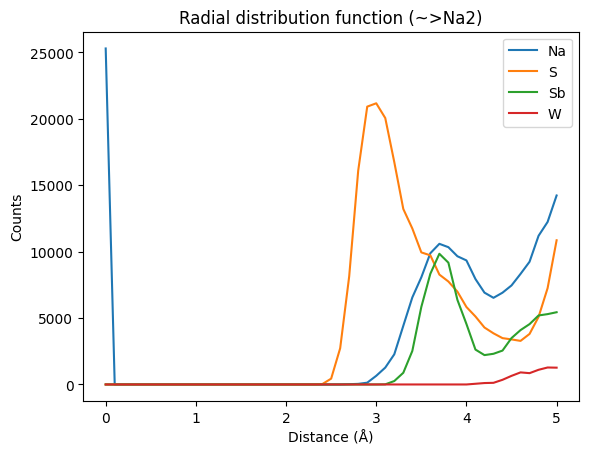

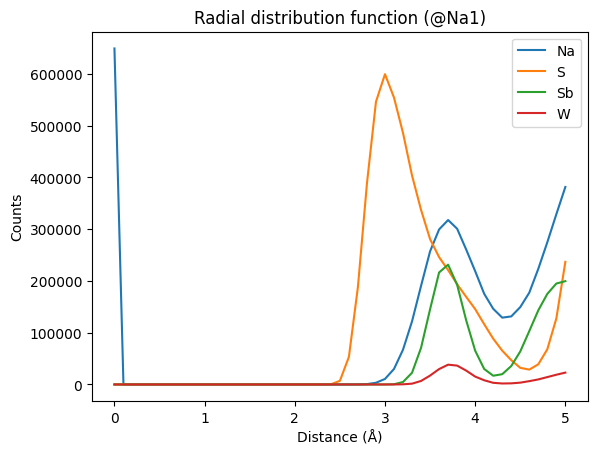

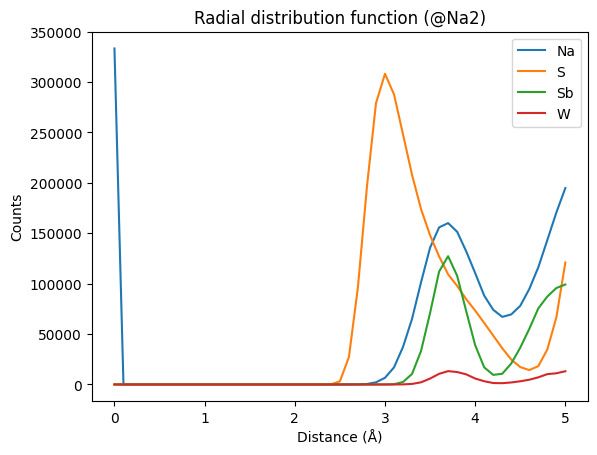

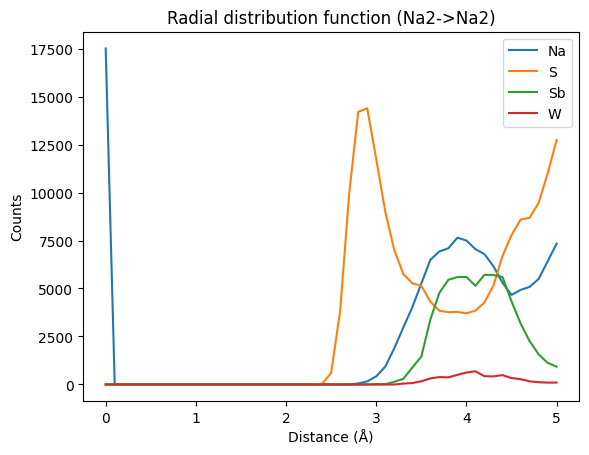

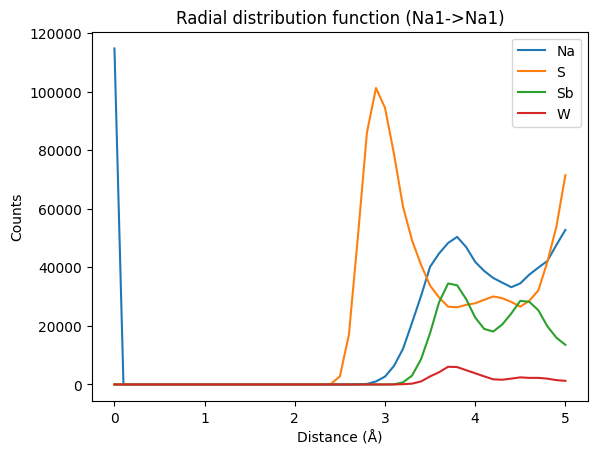

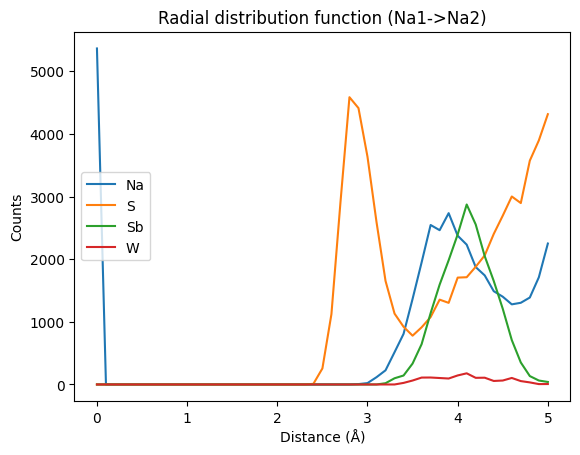

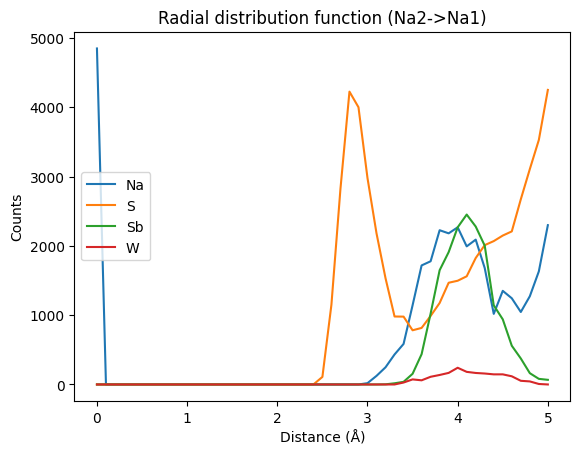

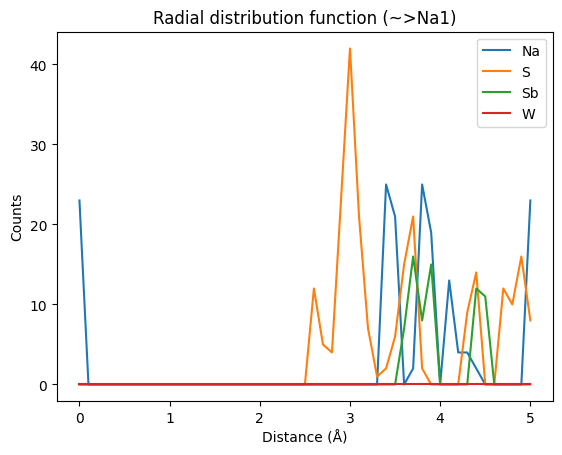

In [34]:
# Compute the site-specific RDF
rdf_data = transitions.radial_distribution(
    floating_specie='Na',
)

# Plot the results
for rdfs in rdf_data.values():
    fig = rdfs.plot(backend='matplotlib')
    fig.show()

You can also get the **atom locations** (fraction of Na atoms occupying each site type) and the **occupancy** (fraction of sites occupied by Na atoms) over time.

In [35]:
# Calculate atom locations per site type
atom_locations = transitions.atom_locations()
print(f'Atom locations per site type: "Na1":{atom_locations["Na1"]:.2f}, "Na2":{atom_locations["Na2"]:.2f}')

# Calculate average occupancy per site type
average_occupancy = transitions.occupancy_by_site_type()
print(f'Average occupancy per site type: "Na1":{average_occupancy["Na1"]:.2f}, "Na2":{average_occupancy["Na2"]:.2f}')

# Retrieve occupancy for each individual site
occupancy = transitions.occupancy()
occupancy

Atom locations per site type: "Na1":0.56, "Na2":0.31
Average occupancy per site type: "Na1":0.81, "Na2":0.88


Structure Summary
Lattice
    abc : 14.2942 14.2942 14.4762
 angles : 90.0 90.0 90.0
 volume : 2957.837312923368
      A : np.float64(14.2942) np.float64(0.0) np.float64(8.752673138186048e-16)
      B : np.float64(2.298682677900778e-15) np.float64(14.2942) np.float64(8.752673138186048e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(14.4762)
    pbc : True True True
PeriodicSite: Na1 (Na:0.733) (5.747e-16, 3.574, 3.192) [0.0, 0.25, 0.2205]
PeriodicSite: Na1 (Na:0.874) (5.747e-16, 3.574, 10.43) [0.0, 0.25, 0.7205]
PeriodicSite: Na1 (Na:0.632) (1.724e-15, 10.72, 3.192) [2.465e-32, 0.75, 0.2205]
PeriodicSite: Na1 (Na:0.855) (1.724e-15, 10.72, 10.43) [2.465e-32, 0.75, 0.7205]
PeriodicSite: Na1 (Na:0.89) (7.147, 3.574, 3.192) [0.5, 0.25, 0.2205]
PeriodicSite: Na1 (Na:0.546) (7.147, 3.574, 10.43) [0.5, 0.25, 0.7205]
PeriodicSite: Na1 (Na:0.871) (7.147, 10.72, 3.192) [0.5, 0.75, 0.2205]
PeriodicSite: Na1 (Na:0.814) (7.147, 10.72, 10.43) [0.5, 0.75, 0.7205]
PeriodicSite: Na1 (Na:0.846

> **Note**:
> - Atom locations differ from occupancy:
> $$atom\_locations = \frac{1}{n_{atoms}} \sum_{i}^{n_{sites^i}} \sum_{k}^{n_{atoms}} \frac{t_{occupied}}{t_{total}}$$
> $$average\_occupancy = \frac{1}{n_{sites^i}} \sum_{i}^{n_{sites^i}} \sum_{k}^{n_{atoms}} \frac{t_{occupied}}{t_{total}}$$
> where $n_{atoms}$ - number of floating atoms; $n_{sites^i}$ - number of sites of type $i$; $t_{occupied}$ - number of timesteps when atom $k$ occupies site $i$; $t_{total}$ - total number of timesteps.
>
> - The output of occupancy per each single site is Structure object with occupancies (fraction of time when site is occupied by floating atoms) set on each site.

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <li>Experiment with various <code>site_radius</code> values in <code>transitions_between_sites</code> function. Calculate and compare the resulting RDFs, atom locations, and occupancy.</li>
> </div>

#### 4. Analysis of jumps

When crystallographic sites are known, it’s straightforward to detect transitions between them. The jumps data is stored in a DataFrame, including the atom index, start and destination site indices, and time steps of the jump.

> **Note**
> To avoid overcounting vibrations at the site boundary as transitions, GEMDAT offers parameters like `site_inner_fraction` (distance threshold) and `minimal_residence` (time threshold).

> 1) The **distance threshold**. With specified radius of inner sphere, the jump will be counted when the atom leaves the inner sphere of starting site and enters the inner sphere of the destination site.
>
> 2) The **time threshold**. When the atom arrives to destination site it should spend several time steps at the destination site before jump is counted.

Below, we illustrate how to use these parameters.

In [36]:
transitions = trajectory.transitions_between_sites(
    sites=custom_structure_2,
    floating_specie='Na',
    site_radius={'Na1':1.5, 'Na2':1.5},
    site_inner_fraction=1.0, # The fraction of site_radius considered "inner"
)

# minimal_residence=0 means no time threshold is required once the atom arrives
jumps = transitions.jumps(minimal_residence=0)
jumps.data

atom index  start site  destination site  start time  stop time
0            0          33                 3       14203      14370
1            0           3                33       14908      15017
2            1          34                 2        2990       3091
3            1           2                26        5960       6029
4            1          26                 2       11205      11261
..         ...         ...               ...         ...        ...
84          44          34                 2       16587      16674
85          44           2                34       17206      17328
86          44          34                 2       17359      17424
87          45          23                15        5159       5261
88          45          15                22        7614       7693

[89 rows x 5 columns]

We can visualize statistics of jump distances and occurrences over time.

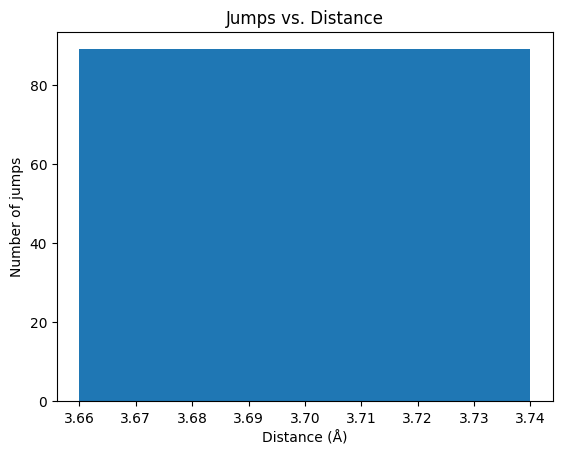

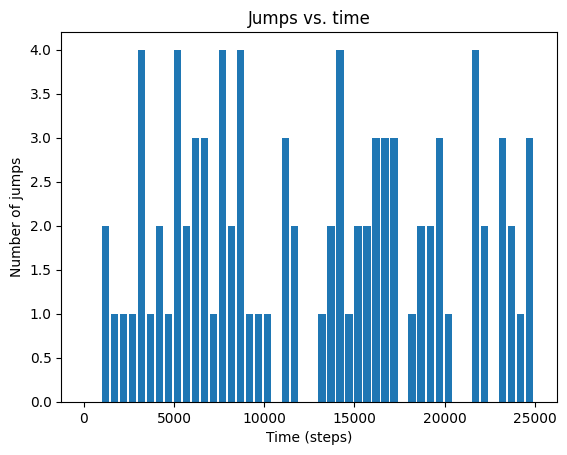

In [37]:
# Plot jumps vs distance and jumps vs time
fig = jumps.plot_jumps_vs_distance(backend='matplotlib')
fig.show()
fig = jumps.plot_jumps_vs_time(backend='matplotlib')
fig.show()

We can also depict the jumps as lines between sites in 3D, with the line width reflecting how many jumps occurred.

In [38]:
jumps.plot_jumps_3d()

From the jump data, you can count the **number of jumps** ($J_i$) and get the **mean jump rate** ($Γ_i$) using
$$Γ_i = \frac{J_i}{Nt}$$
where $N$ is the number of diffusing atoms, the subscript $i$ defines a type of jump, and $t$ is the simulation time.

To get an estimate of the uncertainty in the jump rate the MD simulation is divided into ten different parts (this parameter can be adjusted).

In [39]:
# Total number of jumps
number_jumps = jumps.n_jumps
print(f"Total number of jumps: {number_jumps}")

# Mean jump rates (per jump type), with std if multiple parts are used
jump_rates = jumps.rates(n_parts=5)
print(f"\nMean jump rates (total jumps / second) with std per jump type: \n",round(jump_rates,2))

Total number of jumps: 89

Mean jump rates (total jumps / second) with std per jump type: 
                 rates           std
Na1 Na1  1.260870e+10  6.942921e+09
    Na2  1.260870e+10  6.770614e+09
Na2 Na1  1.304348e+10  4.611566e+09
    Na2  0.000000e+00  0.000000e+00


You can also calculate the **jump rate diffusivity** ($D_J$) via the Einstein–Smulochowski relation:
$$D_J = \sum_{i} \frac{Γ_ia_i^2}{2d}$$
where $i$ are the different types of jumps, $a_i$ is the jump distance of jump type $i$, and $d$ the number of diffusion dimensions. The sum is over all types of jumps, since in most solid electrolytes several different types of jumps contribute to macroscopic diffusion.

In [40]:
jump_diffusivity = jumps.jump_diffusivity(dimensions=3)
print(f"Average jump diffusivity: {jump_diffusivity:.2e} m²/s")

Average jump diffusivity: 8.50e-10 m²/s


If you run MD simulations at multiple temperatures, you can fit an Arrhenius equation to find the activation energy. Alternatively, you can compute the **activation energy** ($ΔE_i^A$) for a jump type ($i$) at a given temperature:
$$ΔE_i^A = -k_B T ln(\frac{Γ_i^{eff}}{ν^*})$$
where $k_B$ is Boltzmann’s constant, $T$ the temperature in Kelvin, $Γ_i^{eff}$ the effective jump frequency, and $ν^*$ the attempt frequency.

The activation energy can be seen as a measure for the jump probability: if the activation energy is low, the jump probability is high, and vice versa.

A jump from site A to B can have a different energy barrier as the reverse jump due to the difference in site energy, even though the number of A−B and B−A jumps will be the same in equilibrium. The amount of time an atom spends at a certain site should be taken into account to correctly determine the activation energy. The effective jump rate, $Γ_i^{eff}$, thus differs from the jump rate by taking into account the fraction of time that the diffusing atoms occupy a type of site ($o_j$):
$$Γ_i^{eff} = \frac{J_i}{tNo_j}$$
where $t$ is the total simulated time, and $N$ the number of diffusing atoms.

By incorporating site occupancy the sites with lower occupancy will have lower activation energies, correctly representing the difference in activation energy between A−B and B−A jumps.

In [41]:
act_energy = jumps.activation_energies(n_parts=5)
print(f"Mean activation energy (eV) per jump type:\n{act_energy}")

Mean activation energy (eV) per jump type:
           energy       std
Na1 Na1  0.268854  0.027840
    Na2  0.242375  0.037966
Na2 Na1  0.203599  0.017775
    Na2       inf       NaN


If jumps occur in quick succession within a chosen radius and timescale, they can be classified as **collective**. GEMDAT identifies these by checking whether multiple jumps happen within one vibration period ($\frac{1}{ν^*}$ seconds) and within some spatial threshold.

In [42]:
# Number of solo (i.e., not collective) jumps
solo_jumps = jumps.n_solo_jumps
frac_solo_jumps = jumps.solo_fraction
print(f"Number of solo (not collective) jumps: {solo_jumps}, "
      f"fraction of solo jumps = {frac_solo_jumps:.2f}")

Number of solo (not collective) jumps: 58, fraction of solo jumps = 0.65


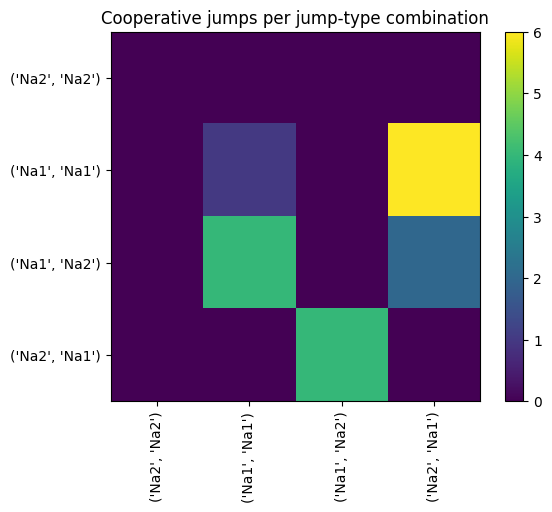

In [43]:
# Plot correlated jumps
fig = jumps.plot_collective_jumps(backend='matplotlib')
fig.show()

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <li>Experiment with various <code>site_radius</code> and <code>site_inner_fraction</code> values in <code>transitions_between_sites</code> function and <code>minimal_residence</code> values in <code>transitions.jumps</code> function. Calculate and compare the resulting jump rates, activation energies, or jump diffusivities. Consider changing <code>n_parts</code> parameter.</li>
> </div>

#### 5. Shape analysis

GEMDAT provides a generalized shape analysis algorithm (`ShapeAnalyzer`) for symmetrical clusters. You supply:
1. A symmetrized structure with unique sites.
2. A trajectory in P1 (supercell) format.

The algorithm folds the trajectory back onto the asymmetric unit and gathers localized positions. This is useful for cluster-based shape analysis, plots, and more.

Below, we demonstrate constructing the `ShapeAnalyzer` from a structure.
>
> **Note:**
> Do **not** apply supercell to loaded structure, it will be applied later.


In [44]:
# Adjusting the loaded structure, do not apply supercell
custom_structure_1 = read_cif('data/structure_2.cif')

# Remove other species besides the floating specie (Na)
custom_structure_1.remove_species(['S','Sb','W'])

# Replace partial occupancies with full occupancy for the floating species
for idx,site in enumerate(custom_structure_1.sites):
    custom_structure_1 = custom_structure_1.replace(
        idx=idx,
        species=site.species.elements[0],
        label=site.label
    )

# Create the shape analyzer by symmetrizing the input structure
sa = ShapeAnalyzer.from_structure(custom_structure_1)

Next, we run shape analysis by specifying a radius (in Å) that determines which trajectory points belong to the cluster.
The supercell is used to fold the trajectory coordinates to the same lattice as the input sites. A warning will be raised if the lattices are not close. Alternatively, you can pass any numpy array with fractional coordinates to `sa.analyze_positions()`

In [45]:
supercell = (2, 2, 2)
radius = 1.6  # Å

# Analyze the trajectory around each site in the asymmetry
shapes = sa.analyze_trajectory(
    trajectory=diff_trajectory,
    supercell=supercell,
    radius=radius,
)

shapes[0]

ShapeData(site=PeriodicSite: Na1 (Na) (5.747e-16, 3.574, 3.192) [0.0, 0.5, 0.441], coords=array([[-0.07769055, -0.54465147,  0.52106879],
       [ 0.05689177,  0.15704709,  0.34339095],
       [ 0.07767411,  0.5446559 ,  0.5210824 ],
       ...,
       [ 0.08375772, -0.04816002,  0.64845269],
       [ 0.09194244, -0.29283055,  0.22940695],
       [ 0.11013424, -0.27257982, -0.46981103]], shape=(3050644, 3)), radius=1.6)

In [46]:
shapes[1]

ShapeData(site=PeriodicSite: Na2 (Na) (0.0, 0.0, 3.619) [0.0, 0.0, 0.5], coords=array([[-2.24418940e-05,  4.44549620e-05, -9.03223680e-02],
       [ 2.29868269e-23,  1.42942001e-07,  1.22648157e-02],
       [-1.08635920e-05,  3.00178200e-06,  1.22693033e-02],
       ...,
       [-3.57025090e-01, -1.20417914e-01, -1.91029962e-01],
       [ 3.17042497e-01, -1.34509708e-01,  7.08935704e-02],
       [ 5.84556449e-01,  1.24576955e-01, -2.60905132e-01]],
      shape=(3010776, 3)), radius=1.6)

We can plot the resulting shape data. Each shape is a set of coordinates (centered on a particular site) from the entire simulation. You can include nearby sites on the plot for context by using `sites` parameter.

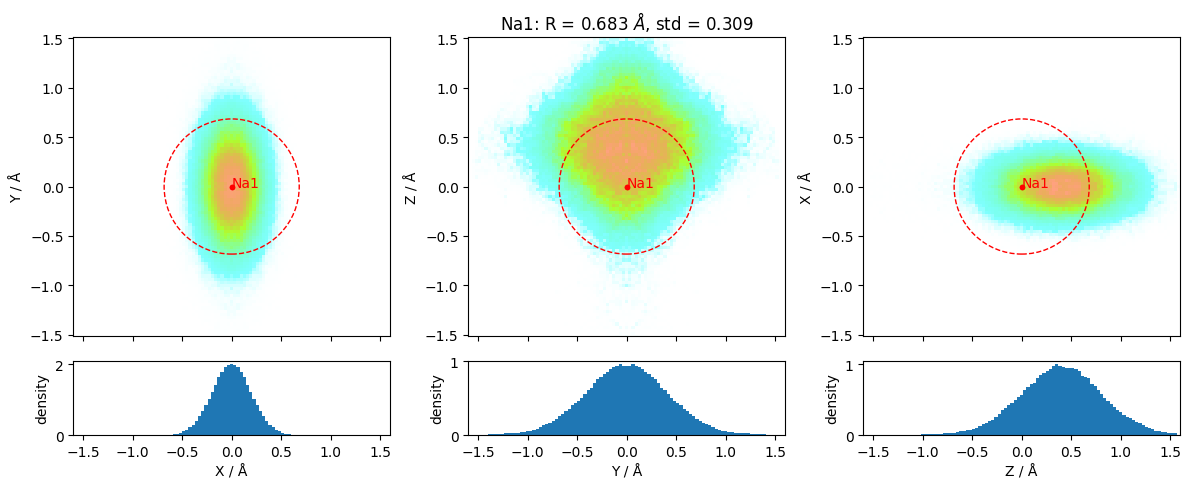

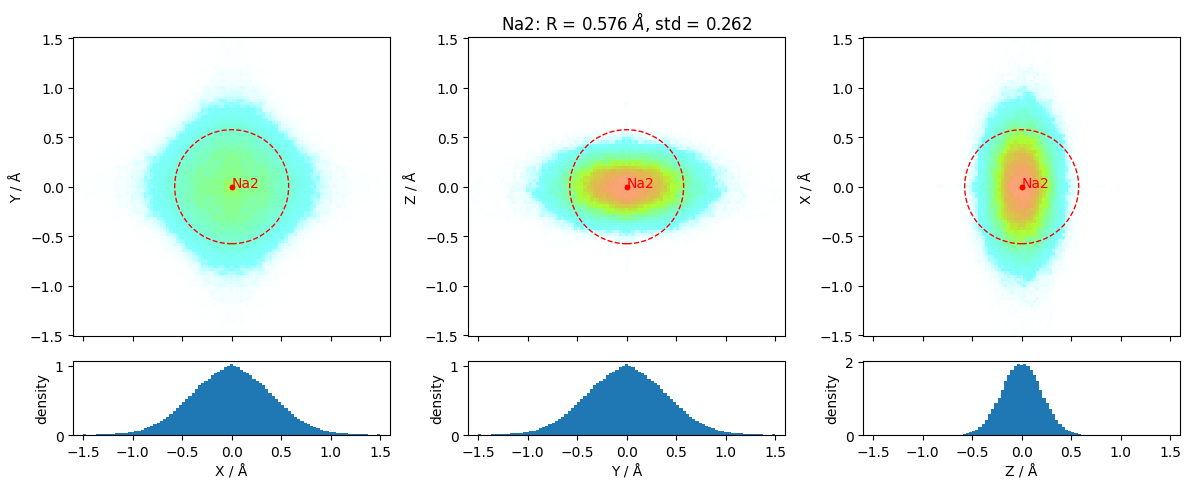

In [47]:
bins = np.linspace(-radius, radius, 100)

# Plot the 2D histograms (XY, XZ, YZ) of positions around each unique site
for shape in shapes:
    sites = custom_structure_1.get_sites_in_sphere(pt=shape.origin, r=radius)
    fig = shape.plot(bins=bins, sites=sites, backend='matplotlib')
    fig.show()

> <div style="border: 1px solid #bce8f1; background-color: #d9edf7; padding: 10px; border-radius: 4px;">
>   <p style="margin: 0; font-weight: bold;">Task for You:</p>
>   <li>Run <code>ShapeAnalyzer</code> and plot shapes for each unique site loading <code>structure_2.cif</code>.</li>
> </div>

You can **optimize site positions** using the `ShapeAnalyzer.optimize_sites()` method, which aligns site centroids to the center of mass of the shape.

In [48]:
sa_shifted = sa.optimize_sites(shapes=shapes)
sa_shifted

ShapeAnalyzer
    Spacegroup
        P4_2/nmc (137)
    Lattice
        abc   :   7.147100   7.147100   7.238100
        angles:  90.000000  90.000000  90.000000
    Unique sites (2)
        PeriodicSite: Na1 (Na) (4.713e-16, 3.574, 3.584) [-1.446e-17, 0.5, 0.4952]
        PeriodicSite: Na2 (Na) (-9.316e-17, 5.477e-18, 3.619) [-1.303e-17, 7.663e-19, 0.5]

Alternatively, you can shift sites by a custom vector array.

In [49]:
vectors = (
    [1, 0, 0],
    [2, 0, 0],
    [3, 0, 0],
)

sa_shifted = sa.shift_sites(vectors=vectors)
sa_shifted

ShapeAnalyzer
    Spacegroup
        P4_2/nmc (137)
    Lattice
        abc   :   7.147100   7.147100   7.238100
        angles:  90.000000  90.000000  90.000000
    Unique sites (2)
        PeriodicSite: Na1 (Na) (1.0, 3.574, 3.192) [0.1399, 0.5, 0.441]
        PeriodicSite: Na2 (Na) (2.0, 0.0, 3.619) [0.2798, 0.0, 0.5]

Finally, you can retrieve a standard Pymatgen `Structure` object back from the shape analyzer.

In [50]:
sa_shifted = sa_shifted.to_structure()
sa_shifted

Structure Summary
Lattice
    abc : 7.1471 7.1471 7.2381
 angles : 90.0 90.0 90.0
 volume : 369.729664115421
      A : np.float64(7.1471) np.float64(0.0) np.float64(4.376336569093024e-16)
      B : np.float64(1.149341338950389e-15) np.float64(7.1471) np.float64(4.376336569093024e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(7.2381)
    pbc : True True True
PeriodicSite: Na1 (Na) (4.574, 0.0, 0.427) [0.6399, 0.0, 0.059]
PeriodicSite: Na1 (Na) (3.574, 1.0, 4.046) [0.5, 0.1399, 0.559]
PeriodicSite: Na1 (Na) (6.147, 3.574, 3.192) [0.8601, 0.5, 0.441]
PeriodicSite: Na1 (Na) (4.139e-16, 2.574, 6.811) [0.0, 0.3601, 0.941]
PeriodicSite: Na1 (Na) (7.355e-16, 4.574, 6.811) [0.0, 0.6399, 0.941]
PeriodicSite: Na1 (Na) (1.0, 3.574, 3.192) [0.1399, 0.5, 0.441]
PeriodicSite: Na1 (Na) (2.574, 0.0, 0.427) [0.3601, 0.0, 0.059]
PeriodicSite: Na1 (Na) (3.574, 6.147, 4.046) [0.5, 0.8601, 0.559]
PeriodicSite: Na2 (Na) (5.574, 3.574, 5.601e-16) [0.7798, 0.5, 0.0]
PeriodicSite: Na2 (Na) (3.216e-16

## Conclusion

This tutorial demonstrated several workflows and methods provided by GEMDAT for analyzing MD simulation data:

1. Loading and processing MD trajectories.
2. Calculating vibrational amplitudes, attempt frequencies, MSD, diffusivity, and ionic conductivity.
3. Extracting and analyzing site transitions and jump statistics.
4. Visualizing probability density and performing site-shape analysis.

We hope this guide helps you integrate GEMDAT into your own MD data workflows.

P.S. If you're trying GEMDAT with your data, your experience, questions, bugs you encountered, and suggestions for improvement are important to the success of the project. Feel free to open a new [issue here](https://github.com/GEMDAT-repos/GEMDAT/issues) to ask a question, suggest improvements/new features, or report any bugs that you ran into.